# Sparse Koopman Autoencoder (SKAE)

**Self-contained notebook for Google Colab**

This notebook implements Koopman operator learning for nonlinear dynamical systems using autoencoders with sparsity constraints. It includes:

- **GenericKM**: Standard Koopman autoencoder with MLP encoder
- **SparseKM**: Koopman autoencoder with L1 sparsity regularization  
- **LISTAKM**: Learned Iterative Soft-Thresholding Algorithm (LISTA) based sparse encoder

## Dynamical Systems

| Environment | Dimension | Description |
|------------|-----------|-------------|
| `duffing` | 2D | Duffing oscillator with two stable centers |
| `pendulum` | 2D | Simple pendulum |
| `lotka_volterra` | 2D | Predator-prey dynamics |
| `lorenz63` | 3D | Chaotic Lorenz attractor |
| `parabolic` | 2D | Parabolic attractor (analytical Koopman) |
| `lyapunov` | 2D | Multi-attractor system with Lyapunov dynamics |

---


## 1. Setup & Installation

Install required dependencies for Colab.


In [1]:
# Install dependencies (run once)
%pip install torch matplotlib numpy scipy torchdiffeq --quiet


In [2]:
# Imports
from __future__ import annotations
import json
from abc import ABC, abstractmethod
from dataclasses import dataclass, field, asdict
from datetime import datetime
from pathlib import Path
from typing import Optional, Callable, Dict, Any, List, Sequence, Tuple

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm

try:
    from torchdiffeq import odeint
    HAS_TORCHDIFFEQ = True
except ImportError:
    HAS_TORCHDIFFEQ = False
    print("torchdiffeq not available, using fallback RK4 integration")

try:
    from scipy.spatial import Voronoi
    HAS_SCIPY = True
except ImportError:
    HAS_SCIPY = False

# Check device
if torch.cuda.is_available():
    DEVICE = 'cuda'
    print(f"Using CUDA: {torch.cuda.get_device_name(0)}")
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    DEVICE = 'mps'
    print("Using Apple Metal (MPS)")
else:
    DEVICE = 'cpu'
    print("Using CPU")

print(f"PyTorch version: {torch.__version__}")


Using CUDA: Tesla T4
PyTorch version: 2.9.0+cu126


---

## 2. Configuration System

The configuration system uses Python dataclasses for type-safe, native Python configuration.

### Available Configurations

- `"default"`: Base configuration with minimal settings
- `"generic"`: Standard KoopmanAE with MLP encoder (64-dim latent)
- `"generic_sparse"`: KoopmanAE with L1 sparsity regularization. This is the main one that is used in the original notebook and for most of the experiments up till now.
- `"generic_prediction"`: Prediction-focused (no reconstruction)
- `"lista"`: LISTA-based sparse autoencoder (2048-dim latent)
- `"lista_nonlinear"`: LISTA with nonlinear MLP encoder

### Config Structure

```
Config
├── SEED: int
├── ENV: EnvConfig
│   ├── ENV_NAME: str (system choice)
│   └── <SYSTEM>: SystemConfig (dt, params)
├── MODEL: ModelConfig
│   ├── MODEL_NAME: str
│   ├── TARGET_SIZE: int (latent dim)
│   ├── Loss coefficients (RES_COEFF, RECONST_COEFF, etc.)
│   ├── ENCODER: EncoderConfig
│   └── DECODER: DecoderConfig
└── TRAIN: TrainConfig
    ├── NUM_STEPS: int (epochs)
    ├── BATCH_SIZE: int
    ├── LR: float
    └── DATA_SIZE: int
```


In [3]:
# =============================================================================
# CONFIGURATION SYSTEM (config.py)
# =============================================================================

@dataclass
class ParabolicConfig:
    """Parabolic attractor system parameters."""
    LAMBDA: float = -1.0
    MU: float = -0.1
    DT: float = 0.1


@dataclass
class DuffingConfig:
    """Duffing oscillator system parameters."""
    DT: float = 0.01


@dataclass
class PendulumConfig:
    """Pendulum system parameters."""
    DT: float = 0.01


@dataclass
class LotkaVolterraConfig:
    """Lotka-Volterra system parameters."""
    DT: float = 0.01


@dataclass
class Lorenz63Config:
    """Lorenz63 system parameters."""
    DT: float = 0.01


@dataclass
class LyapunovConfig:
    """Lyapunov multi-attractor system parameters."""
    DT: float = 0.05
    SIGMA: float = 0.5


@dataclass
class EnvConfig:
    """Environment configuration."""
    ENV_NAME: str = "duffing"
    PARABOLIC: ParabolicConfig = field(default_factory=ParabolicConfig)
    DUFFING: DuffingConfig = field(default_factory=DuffingConfig)
    PENDULUM: PendulumConfig = field(default_factory=PendulumConfig)
    LOTKA_VOLTERRA: LotkaVolterraConfig = field(default_factory=LotkaVolterraConfig)
    LORENZ63: Lorenz63Config = field(default_factory=Lorenz63Config)
    LYAPUNOV: LyapunovConfig = field(default_factory=LyapunovConfig)


@dataclass
class ListaConfig:
    """LISTA encoder-specific configuration."""
    NUM_LOOPS: int = 10
    L: float = 1e3
    ALPHA: float = 0.1
    LINEAR_ENCODER: bool = False


@dataclass
class EncoderConfig:
    """Encoder architecture configuration."""
    LAYERS: List[int] = field(default_factory=lambda: [16, 16])
    LAST_RELU: bool = False
    USE_BIAS: bool = False
    ACTIVATION: str = "relu"  # from ["relu", "tanh", "gelu"]. could try other activations later on
    LISTA: ListaConfig = field(default_factory=ListaConfig)


@dataclass
class DecoderConfig:
    """Decoder architecture configuration."""
    LAYERS: List[int] = field(default_factory=list)
    USE_BIAS: bool = False
    ACTIVATION: str = "relu"


@dataclass
class ModelConfig:
    """Model architecture and loss configuration."""
    MODEL_NAME: str = "SparseKM"  # from ["GenericKM", "SparseKM", "LISTAKM"]
    NORM_FN: str = "id"  # from ["id", "ball"]
    TARGET_SIZE: int = 16  # latent_dim i.e. zdim

    # Loss coefficients
    RES_COEFF: float = 1.0  # alignment loss weight
    RECONST_COEFF: float = 0.02  # reconstruction loss weight
    PRED_COEFF: float = 0.0  # prediction loss weight
    SPARSITY_COEFF: float = 1e-3  # sparsity loss weight (L1 regularization)

    ENCODER: EncoderConfig = field(default_factory=EncoderConfig)
    DECODER: DecoderConfig = field(default_factory=DecoderConfig)


@dataclass
class TrainConfig:
    """Training configuration."""
    NUM_STEPS: int = 2_000
    BATCH_SIZE: int = 256
    DATA_SIZE: int = 256 * 8
    LR: float = 1e-4  # main learning rate (encoder/decoder)
    WEIGHT_DECAY: float = 1e-4  # weight decay for AdamW optimizer
    K_MATRIX_LR: float = 1e-5  # learning rate for Koopman matrix parameters
    USE_SEQUENCE_LOSS: bool = False  # by default, we use single step loss
    SEQUENCE_LENGTH: int = 10


@dataclass
class Config:
    """Main configuration container."""
    SEED: int = 0
    ENV: EnvConfig = field(default_factory=EnvConfig)
    MODEL: ModelConfig = field(default_factory=ModelConfig)
    TRAIN: TrainConfig = field(default_factory=TrainConfig)

    def to_dict(self) -> dict:
        return asdict(self)

    def to_json(self, filepath: str) -> None:
        with open(filepath, 'w') as f:
            json.dump(self.to_dict(), f, indent=2)

    @classmethod
    def from_dict(cls, config_dict: dict) -> "Config":
        env_dict = config_dict.get("ENV", {})
        env = EnvConfig(
            ENV_NAME=env_dict.get("ENV_NAME", "duffing"),
            PARABOLIC=ParabolicConfig(**env_dict.get("PARABOLIC", {})),
            DUFFING=DuffingConfig(**env_dict.get("DUFFING", {})),
            PENDULUM=PendulumConfig(**env_dict.get("PENDULUM", {})),
            LOTKA_VOLTERRA=LotkaVolterraConfig(**env_dict.get("LOTKA_VOLTERRA", {})),
            LORENZ63=Lorenz63Config(**env_dict.get("LORENZ63", {})),
            LYAPUNOV=LyapunovConfig(**env_dict.get("LYAPUNOV", {})),
        )

        model_dict = config_dict.get("MODEL", {})
        encoder_dict = model_dict.get("ENCODER", {})
        lista = ListaConfig(**encoder_dict.get("LISTA", {}))
        encoder = EncoderConfig(**{k: v for k, v in encoder_dict.items() if k != "LISTA"})
        encoder.LISTA = lista
        decoder = DecoderConfig(**model_dict.get("DECODER", {}))

        model = ModelConfig(**{k: v for k, v in model_dict.items() if k not in ["ENCODER", "DECODER"]})
        model.ENCODER = encoder
        model.DECODER = decoder

        train = TrainConfig(**config_dict.get("TRAIN", {}))

        return cls(
            SEED=config_dict.get("SEED", 0),
            ENV=env,
            MODEL=model,
            TRAIN=train
        )

    @classmethod
    def from_json(cls, filepath: str) -> "Config":
        with open(filepath, 'r') as f:
            config_dict = json.load(f)
        return cls.from_dict(config_dict)


def get_default_config() -> Config:
    return Config()


def get_train_generic_km_config() -> Config:
    """Training configuration for GenericKM (standard Koopman AE with MLP encoder)."""
    cfg = Config()
    cfg.TRAIN.LR = 1e-4
    cfg.MODEL.MODEL_NAME = "GenericKM"
    cfg.MODEL.TARGET_SIZE = 64
    cfg.MODEL.NORM_FN = "id"
    cfg.MODEL.DECODER.LAYERS = []
    cfg.MODEL.ENCODER.LAYERS = [64, 64]
    cfg.MODEL.SPARSITY_COEFF = 0.0
    return cfg


def get_train_generic_sparse_config() -> Config:
    """Training configuration for GenericKM with L1 regularization."""
    cfg = Config()
    cfg.TRAIN.LR = 1e-4
    cfg.MODEL.MODEL_NAME = "GenericKM"
    cfg.MODEL.TARGET_SIZE = 64
    cfg.MODEL.NORM_FN = "id"
    cfg.MODEL.DECODER.LAYERS = []
    cfg.MODEL.ENCODER.LAYERS = [64, 64]
    cfg.MODEL.ENCODER.LAST_RELU = True
    cfg.MODEL.ENCODER.USE_BIAS = True
    cfg.MODEL.RECONST_COEFF = 0.5
    cfg.MODEL.SPARSITY_COEFF = 0.01
    return cfg


def get_train_generic_prediction_config() -> Config:
    """Training configuration for prediction-focused KoopmanAE."""
    cfg = Config()
    cfg.MODEL.MODEL_NAME = "GenericKM"
    cfg.TRAIN.LR = 1e-3
    cfg.MODEL.DECODER.LAYERS = []
    cfg.MODEL.PRED_COEFF = 1.0
    cfg.MODEL.RES_COEFF = 0.0
    cfg.MODEL.RECONST_COEFF = 0.0
    cfg.MODEL.SPARSITY_COEFF = 0.0
    return cfg


def get_train_lista_config() -> Config:
    """Configuration for LISTA-based Sparse KM."""
    cfg = Config()
    cfg.MODEL.MODEL_NAME = "LISTAKM"
    cfg.MODEL.ENCODER.LISTA.LINEAR_ENCODER = True
    cfg.MODEL.ENCODER.LISTA.NUM_LOOPS = 10
    cfg.MODEL.TARGET_SIZE = 1024 * 2
    cfg.MODEL.RES_COEFF = 1.0
    cfg.MODEL.RECONST_COEFF = 1.0
    cfg.MODEL.PRED_COEFF = 0.0
    cfg.MODEL.SPARSITY_COEFF = 1.0
    cfg.MODEL.NORM_FN = "id"
    cfg.MODEL.ENCODER.LISTA.L = 0.1
    cfg.MODEL.ENCODER.LISTA.ALPHA = 5e-3
    return cfg


def get_train_lista_nonlinear_config() -> Config:
    """Training configuration for LISTA with nonlinear encoder."""
    cfg = Config()
    cfg.MODEL.MODEL_NAME = "LISTAKM"
    cfg.MODEL.ENCODER.LISTA.LINEAR_ENCODER = False
    cfg.MODEL.ENCODER.LAYERS = [64, 64, 64]
    cfg.MODEL.ENCODER.LISTA.NUM_LOOPS = 10
    cfg.MODEL.TARGET_SIZE = 1024 * 2
    cfg.MODEL.RES_COEFF = 1.0
    cfg.MODEL.RECONST_COEFF = 1.0
    cfg.MODEL.PRED_COEFF = 0.0
    cfg.MODEL.SPARSITY_COEFF = 1.0
    cfg.MODEL.NORM_FN = "id"
    cfg.MODEL.ENCODER.LISTA.L = 1e4
    cfg.MODEL.ENCODER.LISTA.ALPHA = 1.0
    cfg.MODEL.ENCODER.LAST_RELU = True
    cfg.MODEL.ENCODER.USE_BIAS = True
    return cfg


_TRAIN_CONFIG_REGISTRY = {
    "generic": get_train_generic_km_config,
    "generic_sparse": get_train_generic_sparse_config,
    "generic_prediction": get_train_generic_prediction_config,
    "lista": get_train_lista_config,
    "lista_nonlinear": get_train_lista_nonlinear_config,
}


def get_config(name: str = "default") -> Config:
    """Get a named configuration.

    Args:
        name: Configuration name. Options:
            - "default": Base configuration
            - "generic": Standard KoopmanMachine
            - "generic_sparse": Sparse KoopmanMachine with L1
            - "generic_prediction": Prediction-focused
            - "lista": LISTA-based KoopmanMachine
            - "lista_nonlinear": LISTA with MLP encoder

    Returns:
        Config for the specified configuration.
    """
    if name == "default":
        return get_default_config()
    if name not in _TRAIN_CONFIG_REGISTRY:
        raise ValueError(f"Unknown config name '{name}'. Available: {list(_TRAIN_CONFIG_REGISTRY.keys())}")
    return _TRAIN_CONFIG_REGISTRY[name]()


print("✓ Configuration system loaded.")
print(f"  Available configs: {list(_TRAIN_CONFIG_REGISTRY.keys())}")


✓ Configuration system loaded.
  Available configs: ['generic', 'generic_sparse', 'generic_prediction', 'lista', 'lista_nonlinear']


---

## 3. Data: Dynamical Systems Environments

This section defines the dynamical systems used for training and evaluation. Each system is implemented as an environment with:

- `reset()`: Sample random initial conditions
- `step()`: Advance the system by one timestep using RK4 integration

### Implemented Systems

This just follows the paper. The only added system not described in the paper is the Lyapunov Multi-Attractor system.

1. **Duffing Oscillator**: Nonlinear oscillator with two stable centers
2. **Pendulum**: Simple pendulum (angle, angular velocity)
3. **Lotka-Volterra**: Predator-prey population dynamics
4. **Lorenz 63**: Chaotic 3D system (butterfly effect)
5. **Parabolic Attractor**: 2D system with analytical Koopman embedding
6. **Lyapunov Multi-Attractor**: 2D system with 13 stable equilibria


In [4]:
# =============================================================================
# DYNAMICAL SYSTEMS ENVIRONMENTS (data.py)
# =============================================================================

class Env(ABC):
    """Base Environment class for dynamical systems."""

    def __init__(self, cfg: Optional[Config] = None):
        self.cfg = cfg

    @abstractmethod
    def reset(self, rng: Optional[torch.Generator] = None) -> torch.Tensor:
        """Reset environment to initial state."""
        pass

    @abstractmethod
    def step(self, state: torch.Tensor, action: Optional[torch.Tensor] = None) -> torch.Tensor:
        """Take one step in the environment."""
        pass

    @property
    def observation_size(self) -> int:
        """Dimensionality of the state space."""
        rng = torch.Generator()
        rng.manual_seed(0)
        reset_state = self.unwrapped.reset(rng)
        return reset_state.shape[-1]

    @property
    def action_size(self) -> int:
        return 0

    @property
    def unwrapped(self) -> 'Env':
        return self


class Wrapper(Env):
    """Base Wrapper class for environment modifications."""

    def __init__(self, env: Env):
        super().__init__(cfg=None)
        self.env = env

    def reset(self, rng: Optional[torch.Generator] = None) -> torch.Tensor:
        return self.env.reset(rng)

    def step(self, state: torch.Tensor, action: Optional[torch.Tensor] = None) -> torch.Tensor:
        return self.env.step(state, action)

    @property
    def observation_size(self) -> int:
        return self.env.observation_size

    @property
    def action_size(self) -> int:
        return self.env.action_size

    @property
    def unwrapped(self) -> Env:
        return self.env.unwrapped


class VectorWrapper(Wrapper):
    """Wrapper for vectorized/batched environment operations."""

    def __init__(self, env: Env, batch_size: int):
        super().__init__(env)
        self.batch_size = batch_size

    def reset(self, rng: Optional[torch.Generator] = None) -> torch.Tensor:
        if rng is None:
            rng = torch.Generator()
        base_seed = rng.initial_seed()
        states = []
        for i in range(self.batch_size):
            env_rng = torch.Generator().manual_seed(base_seed + i)
            states.append(self.env.reset(env_rng))
        return torch.stack(states, dim=0)

    def step(self, state: torch.Tensor, action: Optional[torch.Tensor] = None) -> torch.Tensor:
        if action is None:
            return torch.vmap(lambda s: self.env.step(s, None))(state)
        else:
            return torch.vmap(lambda s, a: self.env.step(s, a))(state, action)

    def generate_sequence_batch(
        self,
        rng: Optional[torch.Generator] = None,
        window_length: int = 10,
    ) -> torch.Tensor:
        init_states = self.reset(rng)
        trajectories = generate_trajectory(self.step, init_states, length=window_length)
        sequences = torch.cat([init_states.unsqueeze(0), trajectories], dim=0)
        return sequences.transpose(0, 1)


In [5]:
# Integration utilities

def integrate_euler(
    x: torch.Tensor,
    u: Optional[torch.Tensor],
    dt: float,
    dynamics_fn: Callable[[torch.Tensor, Optional[torch.Tensor]], torch.Tensor]
) -> torch.Tensor:
    """Euler integration step for ODE."""
    return x + dt * dynamics_fn(x, u)


def integrate_rk4(
    x: torch.Tensor,
    u: Optional[torch.Tensor],
    dt: float,
    dynamics_fn: Callable[[torch.Tensor, Optional[torch.Tensor]], torch.Tensor]
) -> torch.Tensor:
    """Fourth-order Runge-Kutta (RK4) integration step for ODE."""
    k1 = dynamics_fn(x, u)
    k2 = dynamics_fn(x + 0.5 * dt * k1, u)
    k3 = dynamics_fn(x + 0.5 * dt * k2, u)
    k4 = dynamics_fn(x + dt * k3, u)
    return x + (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)


def generate_trajectory(
    env_step: Callable[[torch.Tensor, Optional[torch.Tensor]], torch.Tensor],
    init_state: torch.Tensor,
    length: Optional[int] = None,
    rng: Optional[torch.Generator] = None,
    actions: Optional[torch.Tensor] = None
) -> torch.Tensor:
    """Generate a trajectory by repeatedly applying environment step."""
    if actions is None:
        assert length is not None, "Must provide either length or actions"
        states = []
        state = init_state
        for _ in range(length):
            state = env_step(state)
            states.append(state)
        return torch.stack(states, dim=0)
    else:
        states = []
        state = init_state
        for action in actions:
            state = env_step(state, action)
            states.append(state)
        return torch.stack(states, dim=0)


def generate_sequence_window(
    env_step: Callable[[torch.Tensor, Optional[torch.Tensor]], torch.Tensor],
    init_state: torch.Tensor,
    window_length: int,
) -> torch.Tensor:
    """Generate a sequence window including the initial state."""
    states = [init_state]
    state = init_state
    for _ in range(window_length):
        state = env_step(state)
        states.append(state)
    return torch.stack(states, dim=0)


In [6]:
# Dynamical System Implementations

class Pendulum(Env):
    """Pendulum model - freely swinging pole.
    State: [angle, angular_velocity]
    The angle x1 is measured in radians from the downward vertical position.
    Initial conditions sampled uniformly from [-π, π] × [-2, 2].

    Dynamics:
        dot(x1) = x2
        dot(x2) = -(g/L) * sin(x1)
    """
    def __init__(self, cfg: Config):
        super().__init__(cfg)
        self.g_over_l = 9.81 / 1.0
        self.dt = cfg.ENV.PENDULUM.DT

    @property
    def action_size(self) -> int:
        return 0

    def reset(self, rng: Optional[torch.Generator] = None) -> torch.Tensor:
        if rng is None:
            rng = torch.Generator()
        x1 = torch.empty(1).uniform_(-torch.pi, torch.pi, generator=rng)
        x2 = torch.empty(1).uniform_(-2.0, 2.0, generator=rng)
        return torch.tensor([x1.item(), x2.item()], dtype=torch.float32)

    def step(self, state: torch.Tensor, action: Optional[torch.Tensor] = None) -> torch.Tensor:
        def dynamics_fn(state: torch.Tensor, action: Optional[torch.Tensor] = None) -> torch.Tensor:
            x1, x2 = state[0], state[1]
            dx1 = x2
            dx2 = -self.g_over_l * torch.sin(x1)
            return torch.stack([dx1, dx2])
        return integrate_rk4(state, None, self.dt, dynamics_fn)


class Duffing(Env):
    """Duffing Oscillator - damped and force-driven particle model.
    Nonlinear second-order ODE: x'' = x - x^3

    Admits two center points and an unstable fixed point at origin.
    Initial conditions sampled uniformly from [-1.5, 1.5] × [-1, 1].

    Dynamics:
        dot(x1) = x2
        dot(x2) = x1 - x1^3
    """
    def __init__(self, cfg: Config):
        super().__init__(cfg)
        self.dt = cfg.ENV.DUFFING.DT

    @property
    def action_size(self) -> int:
        return 0

    def reset(self, rng: Optional[torch.Generator] = None) -> torch.Tensor:
        if rng is None:
            rng = torch.Generator()
        x1 = torch.empty(1).uniform_(-1.5, 1.5, generator=rng)
        x2 = torch.empty(1).uniform_(-1.0, 1.0, generator=rng)
        return torch.tensor([x1.item(), x2.item()], dtype=torch.float32)

    def step(self, state: torch.Tensor, action: Optional[torch.Tensor] = None) -> torch.Tensor:
        def dynamics_fn(state: torch.Tensor, action: Optional[torch.Tensor] = None) -> torch.Tensor:
            x1, x2 = state[0], state[1]
            dx1 = x2
            dx2 = x1 - x1**3
            return torch.stack([dx1, dx2])
        return integrate_rk4(state, None, self.dt, dynamics_fn)


class LotkaVolterra(Env):
    """Lotka-Volterra predator-prey model.
    State: [prey_population, predator_population]
    """
    def __init__(self, cfg: Config):
        super().__init__(cfg)
        self.alpha = 0.2
        self.beta = 0.2
        self.gamma = 0.2
        self.delta = 0.2
        self.dt = cfg.ENV.LOTKA_VOLTERRA.DT

    @property
    def action_size(self) -> int:
        return 0

    def reset(self, rng: Optional[torch.Generator] = None) -> torch.Tensor:
        if rng is None:
            rng = torch.Generator()
        x1 = torch.empty(1).uniform_(0.02, 3.0, generator=rng)
        x2 = torch.empty(1).uniform_(0.02, 3.0, generator=rng)
        return torch.tensor([x1.item(), x2.item()], dtype=torch.float32)

    def step(self, state: torch.Tensor, action: Optional[torch.Tensor] = None) -> torch.Tensor:
        def dynamics_fn(state: torch.Tensor, action: Optional[torch.Tensor] = None) -> torch.Tensor:
            prey, predator = state[0], state[1]
            dx1 = self.alpha * prey - self.beta * prey * predator
            dx2 = self.delta * prey * predator - self.gamma * predator
            return torch.stack([dx1, dx2])
        return integrate_rk4(state, None, self.dt, dynamics_fn)


class Lorenz63(Env):
    """Lorenz 63 system - chaotic three-dimensional system."""
    def __init__(self, cfg: Config):
        super().__init__(cfg)
        self.sigma = 10.0
        self.rho = 28.0
        self.beta = 8.0 / 3.0
        self.dt = cfg.ENV.LORENZ63.DT

    @property
    def action_size(self) -> int:
        return 0

    def reset(self, rng: Optional[torch.Generator] = None) -> torch.Tensor:
        if rng is None:
            rng = torch.Generator()
        base_point = torch.tensor([0.0, 1.0, 1.05], dtype=torch.float32)
        noise = torch.randn(3, generator=rng, dtype=torch.float32)
        return base_point + noise

    def step(self, state: torch.Tensor, action: Optional[torch.Tensor] = None) -> torch.Tensor:
        def dynamics_fn(state: torch.Tensor, action: Optional[torch.Tensor] = None) -> torch.Tensor:
            x, y, z = state[0], state[1], state[2]
            dx = self.sigma * (y - x)
            dy = x * (self.rho - z) - y
            dz = x * y - self.beta * z
            return torch.stack([dx, dy, dz])
        return integrate_rk4(state, None, self.dt, dynamics_fn)


class Parabolic(Env):
    """Parabolic Attractor - two-dimensional system with parabolic manifold."""
    def __init__(self, cfg: Config):
        super().__init__(cfg)
        self.const_lambda = cfg.ENV.PARABOLIC.LAMBDA
        self.const_mu = cfg.ENV.PARABOLIC.MU
        self.dt = cfg.ENV.PARABOLIC.DT

    @property
    def action_size(self) -> int:
        return 0

    def reset(self, rng: Optional[torch.Generator] = None) -> torch.Tensor:
        if rng is None:
            rng = torch.Generator()
        x1 = torch.empty(1).uniform_(-1.0, 1.0, generator=rng)
        x2 = torch.empty(1).uniform_(-1.0, 1.0, generator=rng)
        return torch.tensor([x1.item(), x2.item()], dtype=torch.float32)

    def step(self, state: torch.Tensor, action: Optional[torch.Tensor] = None) -> torch.Tensor:
        def dynamics_fn(state: torch.Tensor, action: Optional[torch.Tensor] = None) -> torch.Tensor:
            x1, x2 = state[0], state[1]
            dx1 = self.const_mu * x1
            dx2 = self.const_lambda * (x2 - x1**2)
            return torch.stack([dx1, dx2])
        return integrate_rk4(state, None, self.dt, dynamics_fn)


class LyapunovMultiAttractor(Env):
    """Nonlinear 2D system with many exponentially stable equilibria."""
    def __init__(self, cfg: Config):
        super().__init__(cfg)
        self.dt = getattr(cfg.ENV, 'LYAPUNOV', None).DT if hasattr(cfg.ENV, 'LYAPUNOV') else 0.05
        self.sigma = getattr(cfg.ENV, 'LYAPUNOV', None).SIGMA if hasattr(cfg.ENV, 'LYAPUNOV') else 0.5

        self.points = torch.tensor([
            [-1.0, -1.0], [ 1.0, -1.0], [-1.0,  1.0], [ 1.0,  1.0],
            [ 0.0,  0.0],
            [-1.0, -2.0], [ 1.0, -2.0], [-1.0,  2.0], [ 1.0,  2.0],
            [-2.0, -1.0], [ 2.0, -1.0], [-2.0,  1.0], [ 2.0,  1.0],
        ], dtype=torch.float32)
        self._sigma2 = float(self.sigma) * float(self.sigma)

    @property
    def action_size(self) -> int:
        return 0

    def reset(self, rng: Optional[torch.Generator] = None) -> torch.Tensor:
        if rng is None:
            rng = torch.Generator()
        x1 = torch.empty(1).uniform_(-2.5, 2.5, generator=rng)
        x2 = torch.empty(1).uniform_(-2.5, 2.5, generator=rng)
        return torch.tensor([x1.item(), x2.item()], dtype=torch.float32)

    def step(self, state: torch.Tensor, action: Optional[torch.Tensor] = None) -> torch.Tensor:
        sigma2 = self._sigma2

        def dynamics_fn(state: torch.Tensor, action: Optional[torch.Tensor] = None) -> torch.Tensor:
            diff = state.unsqueeze(0) - self.points
            r2 = (diff * diff).sum(dim=1)
            normx2 = torch.dot(state, state)
            psi1 = normx2 * torch.exp(-r2 / sigma2)
            term1 = (-2.0 / sigma2) * (psi1.unsqueeze(1) * diff).sum(dim=0)
            psi2 = torch.exp(-r2 / sigma2)
            term2 = -(psi2.unsqueeze(1) * diff).sum(dim=0)
            return term1 + term2

        return integrate_rk4(state, None, self.dt, dynamics_fn)


In [7]:
# Environment Registry and Factory

_ENV_REGISTRY = {
    "pendulum": Pendulum,
    "duffing": Duffing,
    "lotka_volterra": LotkaVolterra,
    "lorenz63": Lorenz63,
    "parabolic": Parabolic,
    "lyapunov": LyapunovMultiAttractor,
}


def make_env(cfg: Config) -> Env:
    """Factory function to create environment from configuration."""
    env_name = cfg.ENV.ENV_NAME
    if env_name not in _ENV_REGISTRY:
        raise ValueError(
            f"Unknown environment '{env_name}'. "
            f"Available: {list(_ENV_REGISTRY.keys())}"
        )
    return _ENV_REGISTRY[env_name](cfg)


print("✓ Dynamical systems loaded.")
print(f"  Available environments: {list(_ENV_REGISTRY.keys())}")


✓ Dynamical systems loaded.
  Available environments: ['pendulum', 'duffing', 'lotka_volterra', 'lorenz63', 'parabolic', 'lyapunov']


---

## 4. Koopman Autoencoder Models

This section implements the Koopman autoencoder architectures:

### Model Components

- **MLPCoder**: Multi-layer perceptron for encoding/decoding
- **LISTA**: Learned Iterative Soft-Thresholding Algorithm for sparse coding
- **KoopmanMachine**: Abstract base class for Koopman operator learning

### Concrete Implementations

- **GenericKM**: Standard Koopman autoencoder with MLP encoder
- **LISTAKM**: Koopman machine with LISTA sparse encoder

### Key Concepts

The Koopman operator is a linear operator that advances measurement functions forward in time through nonlinear system dynamics. The autoencoder learns:

1. **Encoder** (phi): Maps observations x to latent space z = phi(x)
2. **Koopman Matrix** (K): Linear dynamics in latent space z' = K @ z
3. **Decoder** (psi): Maps latent representations back to observations x = psi(z)


In [8]:
# =============================================================================
# KOOPMAN AUTOENCODER MODELS (model.py)
# =============================================================================

def shrink(x: torch.Tensor, threshold: float) -> torch.Tensor:
    """Soft thresholding operator (shrinkage). Used in LISTA."""
    return torch.sign(x) * torch.maximum(torch.abs(x) - threshold, torch.zeros_like(x))


def get_activation(name: str) -> nn.Module:
    """Get activation function by name."""
    activations = {
        'relu': nn.ReLU(),
        'tanh': nn.Tanh(),
        'gelu': nn.GELU(),
    }
    if name not in activations:
        raise ValueError(f"Unknown activation '{name}'. Available: {list(activations.keys())}")
    return activations[name]


class MLPCoder(nn.Module):
    """Multi-layer perceptron for encoding or decoding."""

    def __init__(
        self,
        input_size: int,
        target_size: int,
        hidden_layers: List[int],
        last_relu: bool = False,
        use_bias: bool = False,
        activation: str = 'relu'
    ):
        super().__init__()
        self.input_size = input_size
        self.target_size = target_size
        self.hidden_layers = hidden_layers
        self.last_relu = last_relu

        layers = []
        prev_size = input_size

        for hidden_size in hidden_layers:
            layers.append(nn.Linear(prev_size, hidden_size, bias=use_bias))
            layers.append(get_activation(activation))
            prev_size = hidden_size

        layers.append(nn.Linear(prev_size, target_size, bias=use_bias))
        if last_relu:
            layers.append(nn.ReLU())

        self.network = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)


class LISTA(nn.Module):
    """Learned Iterative Soft-Thresholding Algorithm (LISTA) encoder."""

    def __init__(self, cfg: Config, xdim: int, Wd_init: torch.Tensor):
        super().__init__()
        self.cfg = cfg
        self.xdim = xdim
        self.zdim = cfg.MODEL.TARGET_SIZE
        self.num_loops = cfg.MODEL.ENCODER.LISTA.NUM_LOOPS
        self.alpha = cfg.MODEL.ENCODER.LISTA.ALPHA
        self.L = cfg.MODEL.ENCODER.LISTA.L
        self.use_linear_encode = cfg.MODEL.ENCODER.LISTA.LINEAR_ENCODER

        assert Wd_init.shape == (xdim, self.zdim), \
            f"Wd_init shape {Wd_init.shape} doesn't match expected ({xdim}, {self.zdim})"

        if self.use_linear_encode:
            self.We = nn.Linear(xdim, self.zdim, bias=False)
            with torch.no_grad():
                self.We.weight.copy_((1.0 / self.L) * Wd_init.T)
        else:
            self.We = MLPCoder(
                input_size=xdim,
                target_size=self.zdim,
                hidden_layers=cfg.MODEL.ENCODER.LAYERS,
                use_bias=cfg.MODEL.ENCODER.USE_BIAS,
                last_relu=cfg.MODEL.ENCODER.LAST_RELU,
                activation=cfg.MODEL.ENCODER.ACTIVATION,
            )

        S_init = torch.eye(self.zdim) - (1.0 / self.L) * (Wd_init.T @ Wd_init)
        self.S = nn.Parameter(S_init)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        nonsparse_code = self.We(x)
        z = shrink(nonsparse_code, self.alpha / self.L)
        for _ in range(self.num_loops):
            z = shrink(z @ self.S + nonsparse_code, self.alpha / self.L)
        return z


In [9]:
# Koopman Machine Base Class

class KoopmanMachine(ABC, nn.Module):
    """Abstract base class for Koopman operator learning."""

    def __init__(self, cfg: Config, observation_size: int):
        super().__init__()
        self.cfg = cfg
        self.observation_size = observation_size
        self.target_size = cfg.MODEL.TARGET_SIZE
        self.dt = None

    @abstractmethod
    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """Encode observations to latent space."""
        pass

    @abstractmethod
    def decode(self, y: torch.Tensor) -> torch.Tensor:
        """Decode latent representations to observation space."""
        pass

    @abstractmethod
    def kmatrix(self) -> torch.Tensor:
        """Extract the learned Koopman matrix from parameters."""
        pass

    def residual(self, x: torch.Tensor, nx: torch.Tensor) -> torch.Tensor:
        """Compute alignment loss between consecutive states in latent space."""
        y = self.encode(x)
        ny = self.encode(nx)
        kmat = self.kmatrix()
        return torch.norm(y @ kmat - ny, dim=-1)

    def reconstruction(self, x: torch.Tensor) -> torch.Tensor:
        """Reconstruction via encode-decode."""
        return self.decode(self.encode(x))

    def sparsity_loss(self, x: torch.Tensor) -> torch.Tensor:
        """Compute L1 sparsity loss on latent codes."""
        z = self.encode(x)
        return torch.norm(z, p=1, dim=-1).mean()

    def step_latent(self, y: torch.Tensor) -> torch.Tensor:
        """Step forward in latent space using Koopman matrix."""
        kmat = self.kmatrix()
        return y @ kmat

    def step_env(self, x: torch.Tensor) -> torch.Tensor:
        """Predict next observation using Koopman dynamics."""
        y = self.encode(x)
        ny = self.step_latent(y)
        nx = self.decode(ny)
        return nx

    def koopman_ode_func(self, t: torch.Tensor, z: torch.Tensor) -> torch.Tensor:
        """ODE function for continuous-time Koopman dynamics: dz/dt = K @ z."""
        kmat = self.kmatrix()
        return z @ kmat

    def integrate_latent_ode(
        self,
        z0: torch.Tensor,
        t_span: torch.Tensor,
        method: str = 'dopri5'
    ) -> torch.Tensor:
        """Integrate Koopman dynamics from z0 over time points in t_span."""
        if not hasattr(self, '_printed_ode_method'):
            if HAS_TORCHDIFFEQ:
                print(f"Using torchdiffeq with method '{method}' for ODE integration")
            else:
                print("Using manual RK4 for ODE integration (torchdiffeq not available)")
            self._printed_ode_method = True

        if HAS_TORCHDIFFEQ:
            z_traj = odeint(
                self.koopman_ode_func,
                z0,
                t_span,
                method=method,
                rtol=1e-5,
                atol=1e-7,
            )
            return z_traj
        else:
            return self._integrate_rk4_fallback(z0, t_span)

    def _integrate_rk4_fallback(
        self,
        z0: torch.Tensor,
        t_span: torch.Tensor
    ) -> torch.Tensor:
        """Fallback RK4 integration when torchdiffeq is not available."""
        z_list = [z0]
        z = z0
        for i in range(len(t_span) - 1):
            t = t_span[i]
            dt = t_span[i+1] - t_span[i]
            k1 = self.koopman_ode_func(t, z)
            k2 = self.koopman_ode_func(t + 0.5 * dt, z + 0.5 * dt * k1)
            k3 = self.koopman_ode_func(t + 0.5 * dt, z + 0.5 * dt * k2)
            k4 = self.koopman_ode_func(t + dt, z + dt * k3)
            z = z + (dt / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)
            z_list.append(z)
        return torch.stack(z_list, dim=0)

    def rollout_sequence_ode(
        self,
        x0: torch.Tensor,
        num_steps: int,
        dt: float,
    ) -> torch.Tensor:
        """Rollout a sequence using ODE integration of Koopman dynamics."""
        z0 = self.encode(x0)
        t_span = torch.arange(num_steps + 1, dtype=torch.float32, device=x0.device) * dt
        z_traj = self.integrate_latent_ode(z0, t_span)
        num_times, batch_size, target_size = z_traj.shape
        z_flat = z_traj.reshape(num_times * batch_size, target_size)
        x_flat = self.decode(z_flat)
        x_traj = x_flat.reshape(num_times, batch_size, self.observation_size)
        return x_traj


In [10]:
# Loss functions for KoopmanMachine (continued)

def _koopman_loss(
    self: KoopmanMachine,
    x: torch.Tensor,
    nx: torch.Tensor
) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
    """Compute total loss and metrics (single-step version)."""
    kmat = self.kmatrix()
    prediction = self.decode(self.encode(x) @ kmat)
    prediction_loss = torch.norm(prediction - nx, dim=-1).mean()

    residual_loss = self.residual(x, nx).mean()

    reconst_loss = torch.norm(x - self.reconstruction(x), dim=-1).mean()
    reconst_loss += torch.norm(nx - self.reconstruction(nx), dim=-1).mean()

    sparsity_loss = self.sparsity_loss(x)
    sparsity_loss += self.sparsity_loss(nx)
    sparsity_loss *= 0.5

    with torch.no_grad():
        kmat_device = kmat.device
        if kmat_device.type == 'mps':
            kmat_cpu = kmat.cpu()
            eigvals = torch.linalg.eigvals(kmat_cpu)
        else:
            eigvals = torch.linalg.eigvals(kmat)
        max_eigenvalue = torch.max(eigvals.real)

    with torch.no_grad():
        z = self.encode(x)
        num_nonzero_codes = (z != 0).float().sum(dim=-1).mean()
        sparsity_ratio = 1.0 - num_nonzero_codes / self.target_size

    total_loss = (
        self.cfg.MODEL.RES_COEFF * residual_loss +
        self.cfg.MODEL.RECONST_COEFF * reconst_loss +
        self.cfg.MODEL.PRED_COEFF * prediction_loss +
        self.cfg.MODEL.SPARSITY_COEFF * sparsity_loss
    )

    metrics = {
        'loss': total_loss.item(),
        'residual_loss': residual_loss.item(),
        'reconst_loss': reconst_loss.item(),
        'prediction_loss': prediction_loss.item(),
        'sparsity_loss': sparsity_loss.item(),
        'A_max_eigenvalue': max_eigenvalue.item(),
        'sparsity_ratio': sparsity_ratio.item(),
    }

    return total_loss, metrics


def _koopman_loss_sequence(
    self: KoopmanMachine,
    x_seq: torch.Tensor,
    dt: float,
) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
    """Compute sequence-based loss using ODE integration."""
    batch_size, seq_len, obs_size = x_seq.shape

    x_flat = x_seq.reshape(batch_size * seq_len, obs_size)
    z_flat = self.encode(x_flat)
    z_seq = z_flat.reshape(batch_size, seq_len, self.target_size)

    x0 = x_seq[:, 0, :]
    z0 = z_seq[:, 0, :]

    t_span = torch.arange(seq_len, dtype=torch.float32, device=x_seq.device) * dt
    z_hat_traj = self.integrate_latent_ode(z0, t_span)
    z_hat_seq = z_hat_traj.transpose(0, 1)

    x_tilde = self.decode(z_flat).reshape(batch_size, seq_len, obs_size)

    z_hat_flat = z_hat_seq.reshape(batch_size * seq_len, self.target_size)
    x_hat_flat = self.decode(z_hat_flat)
    x_hat_seq = x_hat_flat.reshape(batch_size, seq_len, obs_size)

    alignment_loss = torch.norm(
        z_hat_seq[:, 1:, :] - z_seq[:, 1:, :],
        dim=-1
    ).pow(2).sum(dim=1).mean()

    reconst_loss = torch.norm(
        x_seq - x_tilde,
        dim=-1
    ).pow(2).sum(dim=1).mean()

    prediction_loss = torch.norm(
        x_seq[:, 1:, :] - x_hat_seq[:, 1:, :],
        dim=-1
    ).pow(2).sum(dim=1).mean()

    sparsity_loss = torch.norm(z_seq, p=1, dim=-1).mean()

    with torch.no_grad():
        kmat = self.kmatrix()
        kmat_device = kmat.device
        if kmat_device.type == 'mps':
            kmat_cpu = kmat.cpu()
            eigvals = torch.linalg.eigvals(kmat_cpu)
        else:
            eigvals = torch.linalg.eigvals(kmat)
        max_eigenvalue = torch.max(eigvals.real)

        num_nonzero_codes = (z_seq != 0).float().sum(dim=-1).mean()
        sparsity_ratio = 1.0 - num_nonzero_codes / self.target_size

    total_loss = (
        self.cfg.MODEL.RES_COEFF * alignment_loss +
        self.cfg.MODEL.RECONST_COEFF * reconst_loss +
        self.cfg.MODEL.PRED_COEFF * prediction_loss +
        self.cfg.MODEL.SPARSITY_COEFF * sparsity_loss
    )

    metrics = {
        'loss': total_loss.item(),
        'alignment_loss': alignment_loss.item(),
        'reconst_loss': reconst_loss.item(),
        'prediction_loss': prediction_loss.item(),
        'sparsity_loss': sparsity_loss.item(),
        'A_max_eigenvalue': max_eigenvalue.item(),
        'sparsity_ratio': sparsity_ratio.item(),
    }

    return total_loss, metrics


# Attach loss methods to KoopmanMachine
KoopmanMachine.loss = _koopman_loss
KoopmanMachine.loss_sequence = _koopman_loss_sequence


In [11]:
# Concrete Model Implementations

class GenericKM(KoopmanMachine):
    """Generic Koopman Machine with MLP encoder and decoder."""

    def __init__(self, cfg: Config, observation_size: int):
        super().__init__(cfg, observation_size)

        self.encoder = MLPCoder(
            input_size=observation_size,
            target_size=cfg.MODEL.TARGET_SIZE,
            hidden_layers=cfg.MODEL.ENCODER.LAYERS,
            use_bias=cfg.MODEL.ENCODER.USE_BIAS,
            last_relu=cfg.MODEL.ENCODER.LAST_RELU,
            activation=cfg.MODEL.ENCODER.ACTIVATION,
        )

        self.decoder = MLPCoder(
            input_size=cfg.MODEL.TARGET_SIZE,
            target_size=observation_size,
            hidden_layers=cfg.MODEL.DECODER.LAYERS,
            use_bias=cfg.MODEL.DECODER.USE_BIAS,
            last_relu=False,
            activation=cfg.MODEL.DECODER.ACTIVATION,
        )

        self.kmat = nn.Parameter(torch.eye(cfg.MODEL.TARGET_SIZE))
        self.norm_fn_name = cfg.MODEL.NORM_FN

    def _norm_fn(self, x: torch.Tensor) -> torch.Tensor:
        if self.norm_fn_name == 'id':
            return x
        elif self.norm_fn_name == 'ball':
            return x / torch.norm(x, dim=-1, keepdim=True)
        else:
            raise ValueError(f"Unknown norm function '{self.norm_fn_name}'")

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        y = self.encoder(x)
        return self._norm_fn(y)

    def decode(self, y: torch.Tensor) -> torch.Tensor:
        return self.decoder(y)

    def kmatrix(self) -> torch.Tensor:
        return self.kmat

    def step_latent(self, y: torch.Tensor) -> torch.Tensor:
        ny = y @ self.kmatrix()
        return self._norm_fn(ny)


class LISTAKM(KoopmanMachine):
    """Koopman Machine with LISTA sparse encoder."""

    def __init__(self, cfg: Config, observation_size: int):
        super().__init__(cfg, observation_size)

        Wd_init = torch.randn(observation_size, cfg.MODEL.TARGET_SIZE) * 0.01
        self.register_buffer('dict_init', Wd_init.clone())
        self.dict = nn.Parameter(Wd_init.T)

        self.lista = LISTA(cfg, observation_size, Wd_init)
        self.kmat = nn.Parameter(torch.eye(cfg.MODEL.TARGET_SIZE))

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        return self.lista(x)

    def decode(self, y: torch.Tensor) -> torch.Tensor:
        wd = self.dict / torch.norm(self.dict, dim=1, keepdim=True).clamp(min=1e-4)
        return y @ wd

    def kmatrix(self) -> torch.Tensor:
        return self.kmat

    def sparsity_loss(self, x: torch.Tensor) -> torch.Tensor:
        z = self.encode(x)
        return self.cfg.MODEL.ENCODER.LISTA.ALPHA * torch.norm(z, p=1, dim=-1).mean()


# Model Registry and Factory

_MODEL_REGISTRY = {
    "GenericKM": GenericKM,
    "SparseKM": GenericKM,
    "LISTAKM": LISTAKM,
}


def make_model(cfg: Config, observation_size: int) -> KoopmanMachine:
    """Factory function to create model from configuration."""
    model_name = cfg.MODEL.MODEL_NAME
    if model_name not in _MODEL_REGISTRY:
        raise ValueError(
            f"Unknown model '{model_name}'. "
            f"Available: {list(_MODEL_REGISTRY.keys())}"
        )
    return _MODEL_REGISTRY[model_name](cfg, observation_size)


print("✓ Koopman autoencoder models loaded.")
print(f"  Available models: {list(_MODEL_REGISTRY.keys())}")


✓ Koopman autoencoder models loaded.
  Available models: ['GenericKM', 'SparseKM', 'LISTAKM']


---

## 5. Training Pipeline

This section implements the training loop for Koopman autoencoders.

### Training Modes

1. **Pairwise (single-step) training**: Uses pairs (x, x') of consecutive states
2. **Sequence training**: Uses sequences of states with ODE integration

### Optimizer

Uses AdamW with separate learning rates for:
- Encoder/Decoder parameters: `cfg.TRAIN.LR`
- Koopman matrix: `cfg.TRAIN.K_MATRIX_LR` (typically smaller)

### Logging

Metrics are logged to JSONL files for later analysis.


In [12]:
# =============================================================================
# TRAINING PIPELINE (train.py)
# =============================================================================

class MetricsLogger:
    """Simple file-based metrics logger."""

    def __init__(self, log_dir: Path, flush_interval: int = 100):
        self.log_dir = log_dir
        self.metrics_file = log_dir / 'metrics_history.jsonl'
        self.metrics_history: List[Dict] = []
        self.buffer: List[str] = []
        self.flush_interval = flush_interval
        self.step_count = 0

    def log_scalar(self, name: str, value: float, step: int):
        entry = {'step': step, 'name': name, 'value': value}
        self.buffer.append(json.dumps(entry) + '\n')
        self.metrics_history.append(entry)
        self.step_count += 1
        if len(self.buffer) >= self.flush_interval:
            self.flush()

    def flush(self):
        if self.buffer:
            with open(self.metrics_file, 'a') as f:
                f.writelines(self.buffer)
            self.buffer.clear()

    def log_dict(self, metrics: Dict[str, float], step: int, prefix: str = ''):
        for key, value in metrics.items():
            name = f"{prefix}/{key}" if prefix else key
            self.log_scalar(name, value, step)

    def close(self):
        self.flush()
        summary_file = self.log_dir / 'metrics_summary.json'
        summary = {}
        metrics_by_name = {}
        for entry in self.metrics_history:
            name = entry['name']
            if name not in metrics_by_name:
                metrics_by_name[name] = []
            metrics_by_name[name].append(entry['value'])

        for name, values in metrics_by_name.items():
            summary[name] = {
                'final': values[-1] if values else None,
                'min': min(values) if values else None,
                'max': max(values) if values else None,
                'mean': sum(values) / len(values) if values else None,
            }

        with open(summary_file, 'w') as f:
            json.dump(summary, f, indent=2)


def train_step(
    model: nn.Module,
    optimizer: torch.optim.Optimizer,
    x: torch.Tensor,
    nx: torch.Tensor,
    cfg: Config,
    dt: float,
) -> Dict[str, float]:
    """Perform one training step."""
    model.train()
    optimizer.zero_grad()

    if cfg.TRAIN.USE_SEQUENCE_LOSS:
        loss, metrics = model.loss_sequence(x, dt)
    else:
        loss, metrics = model.loss(x, nx)

    loss.backward()
    optimizer.step()
    return metrics


def build_optimizer(model: nn.Module, cfg: Config) -> torch.optim.Optimizer:
    """Create optimizer with separate learning rate for Koopman matrix."""
    kmat_params = []
    other_params = []
    for name, param in model.named_parameters():
        if not param.requires_grad:
            continue
        if 'kmat' in name:
            kmat_params.append(param)
        else:
            other_params.append(param)

    param_groups = []
    if other_params:
        param_groups.append({
            'params': other_params,
            'lr': cfg.TRAIN.LR,
            'weight_decay': cfg.TRAIN.WEIGHT_DECAY,
        })
    if kmat_params:
        param_groups.append({
            'params': kmat_params,
            'lr': cfg.TRAIN.K_MATRIX_LR,
            'weight_decay': 0.0,
        })

    return torch.optim.AdamW(param_groups)


def get_dt_from_config(cfg: Config) -> float:
    """Extract dt from environment config."""
    env_name = cfg.ENV.ENV_NAME.lower()
    if env_name == 'duffing':
        return cfg.ENV.DUFFING.DT
    elif env_name == 'pendulum':
        return cfg.ENV.PENDULUM.DT
    elif env_name == 'lotka_volterra':
        return cfg.ENV.LOTKA_VOLTERRA.DT
    elif env_name == 'lorenz63':
        return cfg.ENV.LORENZ63.DT
    elif env_name == 'parabolic':
        return cfg.ENV.PARABOLIC.DT
    elif env_name == 'lyapunov':
        return cfg.ENV.LYAPUNOV.DT
    else:
        return 0.01


In [13]:
# Main training function

def train(
    cfg: Config,
    log_dir: Optional[str] = None,
    checkpoint_path: Optional[str] = None,
    device: str = 'cuda',
    run_evaluation: bool = True,
) -> nn.Module:
    """Main training function.

    Args:
        cfg: Configuration object
        log_dir: Directory for logs and checkpoints
        checkpoint_path: Path to checkpoint to resume from
        device: Device to train on ('cpu', 'cuda', 'mps')
        run_evaluation: Whether to run evaluation after training

    Returns:
        Trained model
    """
    print("Initializing training...")

    # Setup logging directory
    if log_dir is None:
        log_dir = './runs/kae'
    timestamp = datetime.now().strftime("%Y%m%d-%H%M%S")
    run_dir = Path(log_dir) / timestamp
    run_dir.mkdir(parents=True, exist_ok=True)
    cfg.to_json(str(run_dir / 'config.json'))

    logger = MetricsLogger(run_dir)

    # Set random seed
    torch.manual_seed(cfg.SEED)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(cfg.SEED)

    # Create environment
    print("Creating environment...")
    env = make_env(cfg)
    env = VectorWrapper(env, cfg.TRAIN.BATCH_SIZE)

    # Get dt from config
    dt = get_dt_from_config(cfg)

    # Create model
    print("Creating model...")
    model = make_model(cfg, env.observation_size)
    model = model.to(device)
    model.dt = dt

    # Build optimizer
    print("Building optimizer...")
    optimizer = build_optimizer(model, cfg)

    start_step = 0
    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_step = checkpoint.get('step', 0)
        print(f"Resumed from checkpoint at step {start_step}")

    # Pre-generate random number generators
    num_batches = cfg.TRAIN.DATA_SIZE // cfg.TRAIN.BATCH_SIZE
    rngs = [torch.Generator().manual_seed(cfg.SEED + i * cfg.TRAIN.BATCH_SIZE) for i in range(num_batches)]

    print(f"Training {cfg.MODEL.MODEL_NAME} on {cfg.ENV.ENV_NAME}")
    print(f"Device: {device}")
    print(f"Observation size: {env.observation_size}")
    print(f"Target size: {cfg.MODEL.TARGET_SIZE}")
    print(f"Batch size: {cfg.TRAIN.BATCH_SIZE}")
    print(f"Total steps: {cfg.TRAIN.NUM_STEPS}")
    print(f"Log directory: {run_dir}")
    print("-" * 80)

    best_eval_final_error = float('inf')

    for step in range(start_step, cfg.TRAIN.NUM_STEPS):
        rng = rngs[step % num_batches]

        if cfg.TRAIN.USE_SEQUENCE_LOSS:
            x_seq = env.generate_sequence_batch(rng, window_length=cfg.TRAIN.SEQUENCE_LENGTH)
            x_seq = x_seq.to(device)
            nx = None
            metrics = train_step(model, optimizer, x_seq, nx, cfg, dt)
        else:
            x = env.reset(rng)
            nx = env.step(x)
            x = x.to(device)
            nx = nx.to(device)
            metrics = train_step(model, optimizer, x, nx, cfg, dt)

        logger.log_dict(metrics, step, prefix='train')

        if step % 100 == 0:
            if cfg.TRAIN.USE_SEQUENCE_LOSS:
                print(f"Step {step}/{cfg.TRAIN.NUM_STEPS} | "
                      f"Loss: {metrics['loss']:.4f} | "
                      f"Align: {metrics['alignment_loss']:.4f} | "
                      f"Recon: {metrics['reconst_loss']:.4f} | "
                      f"Sparsity: {metrics['sparsity_ratio']:.3f}")
            else:
                print(f"Step {step}/{cfg.TRAIN.NUM_STEPS} | "
                      f"Loss: {metrics['loss']:.4f} | "
                      f"Res: {metrics['residual_loss']:.4f} | "
                      f"Recon: {metrics['reconst_loss']:.4f} | "
                      f"Sparsity: {metrics['sparsity_ratio']:.3f}")

        # Periodic checkpoint saving
        if step % 500 == 0 or step == cfg.TRAIN.NUM_STEPS - 1:
            if cfg.TRAIN.USE_SEQUENCE_LOSS:
                eval_x = x_seq[:4, 0, :]
            else:
                eval_x = x[:4]

            eval_results = quick_evaluate(model, eval_x, lambda s: env.step(s), num_steps=200)
            logger.log_scalar('eval/mean_error', eval_results['mean_error'], step)
            logger.log_scalar('eval/final_error', eval_results['final_error'], step)

            print(f"  Eval | Mean error: {eval_results['mean_error']:.4f} | "
                  f"Final error: {eval_results['final_error']:.4f}")

            checkpoint_dict = {
                'step': step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'config': cfg.to_dict(),
                'metrics': metrics,
            }

            torch.save(checkpoint_dict, run_dir / 'last.pt')

            if eval_results['final_error'] < best_eval_final_error:
                best_eval_final_error = eval_results['final_error']
                torch.save(checkpoint_dict, run_dir / 'checkpoint.pt')
                print(f"  Saved best checkpoint (final eval error: {best_eval_final_error:.4f})")

    # Save final metrics
    with open(run_dir / 'final_metrics.json', 'w') as f:
        json.dump(metrics, f, indent=2)

    logger.close()

    print("-" * 80)
    print(f"Training complete! Checkpoints saved to {run_dir}")

    # Run evaluation if requested
    if run_evaluation:
        print("Running evaluation...")
        eval_results = evaluate_model(
            model=model,
            cfg=cfg,
            device=device,
            output_dir=run_dir / 'evaluation',
        )
        print("Evaluation complete!")

    return model


def quick_evaluate(
    model: nn.Module,
    x: torch.Tensor,
    env_step_fn,
    num_steps: int = 50,
) -> Dict[str, Any]:
    """Quick evaluation helper used during training."""
    model.eval()
    device = next(model.parameters()).device

    with torch.no_grad():
        true_traj = generate_trajectory(env_step_fn, x.cpu(), length=num_steps)
        pred_traj = rollout_every_step_reencode(model, x.to(device), num_steps)

        pred_traj_cpu = pred_traj.cpu()
        step_error = torch.norm(pred_traj_cpu - true_traj, dim=-1).mean(dim=1)

        return {
            "true_trajectory": true_traj,
            "pred_trajectory": pred_traj_cpu,
            "pred_error": step_error,
            "mean_error": step_error.mean().item(),
            "final_error": step_error[-1].item(),
        }


print("✓ Training pipeline loaded.")


✓ Training pipeline loaded.


---

## 6. Evaluation Module

This section implements comprehensive evaluation for trained Koopman models.

### Rollout Strategies

1. **No reencoding** (`no_reencode`): Evolves entirely in latent space
2. **Every-step reencoding** (`every_step`): Reencodes at each step
3. **Periodic reencoding** (`periodic_k`): Reencodes every k steps

### Metrics

- **Horizon-wise MSE**: Mean squared error at specific prediction horizons
- **Cumulative MSE curve**: Time-averaged MSE vs. prediction horizon
- **Per-step L2 error**: Mean L2 error at each prediction step

### Visualizations

- Phase portraits comparing true vs. predicted trajectories
- MSE vs. horizon curves
- Error curves for each rollout mode


In [14]:
# =============================================================================
# EVALUATION MODULE (evaluation.py)
# =============================================================================

# Rollout generators

@torch.no_grad()
def rollout_no_reencode(model: KoopmanMachine, x0: torch.Tensor, horizon: int) -> torch.Tensor:
    """Roll out the Koopman dynamics without reencoding."""
    model.eval()
    device = next(model.parameters()).device
    x0 = x0.to(device)

    latent = model.encode(x0)
    predictions: List[torch.Tensor] = []

    for _ in range(horizon):
        latent = model.step_latent(latent)
        x_pred = model.decode(latent)
        predictions.append(x_pred)

        if not torch.isfinite(x_pred).all():
            nan_frame = torch.full_like(x_pred, torch.nan)
            predictions.extend([nan_frame] * (horizon - len(predictions)))
            break

    return torch.stack(predictions, dim=0)


@torch.no_grad()
def rollout_every_step_reencode(
    model: KoopmanMachine,
    x0: torch.Tensor,
    horizon: int,
) -> torch.Tensor:
    """Roll out the Koopman dynamics with reencoding at every step."""
    model.eval()
    device = next(model.parameters()).device
    state = x0.to(device)
    predictions: List[torch.Tensor] = []

    for _ in range(horizon):
        state = model.step_env(state)
        predictions.append(state)

        if not torch.isfinite(state).all():
            nan_frame = torch.full_like(state, torch.nan)
            predictions.extend([nan_frame] * (horizon - len(predictions)))
            break

    return torch.stack(predictions, dim=0)


@torch.no_grad()
def rollout_periodic_reencode(
    model: KoopmanMachine,
    x0: torch.Tensor,
    horizon: int,
    period: int,
) -> torch.Tensor:
    """Roll out the Koopman dynamics with periodic reencoding every *period* steps."""
    if period <= 0:
        raise ValueError("period must be a positive integer")

    model.eval()
    device = next(model.parameters()).device
    x0 = x0.to(device)

    latent = model.encode(x0)
    predictions: List[torch.Tensor] = []

    for step in range(horizon):
        latent = model.step_latent(latent)
        x_pred = model.decode(latent)
        predictions.append(x_pred)

        if not torch.isfinite(x_pred).all():
            nan_frame = torch.full_like(x_pred, torch.nan)
            predictions.extend([nan_frame] * (horizon - len(predictions)))
            break

        if (step + 1) % period == 0:
            latent = model.encode(x_pred)

    return torch.stack(predictions, dim=0)


In [15]:
# Metric computation helpers

def _compute_horizon_mse(
    squared_errors: torch.Tensor,
    horizon: int,
) -> Tuple[float, float, List[float], int]:
    """Compute mean +/- std MSE for a specific horizon."""
    horizon = min(horizon, squared_errors.size(0))
    horizon_errors = squared_errors[:horizon]
    per_ic = torch.nanmean(horizon_errors, dim=0)
    valid_mask = torch.isfinite(per_ic)

    if valid_mask.sum() == 0:
        return float("nan"), float("nan"), [], 0

    valid_errors = per_ic[valid_mask]
    mean = valid_errors.mean().item()
    std = valid_errors.std(unbiased=False).item() if valid_errors.numel() > 1 else 0.0
    return mean, std, valid_errors.tolist(), int(valid_mask.sum().item())


def _cumulative_mse_curve(squared_errors: torch.Tensor) -> List[float]:
    """Compute cumulative MSE curve averaged across initial conditions."""
    time_steps = squared_errors.size(0)
    steps = torch.arange(1, time_steps + 1, dtype=torch.float32, device=squared_errors.device)
    cumulative = torch.cumsum(squared_errors, dim=0)
    with torch.no_grad():
        curve = torch.nanmean(cumulative / steps.view(-1, 1), dim=1)
    return curve.cpu().tolist()


# Evaluation settings

@dataclass
class EvaluationSettings:
    """Container for evaluation hyper-parameters."""
    systems: Sequence[str] = ("duffing", "lyapunov")
    horizons: Sequence[int] = (100, 1000)
    periodic_reencode_periods: Sequence[int] = (10, 25, 50, 100)
    batch_size: int = 100
    phase_portrait_samples: int = 20
    phase_portrait_length: int = 200
    phase_portrait_reencode_periods: Sequence[int] = (0, 1, 10, 25, 50)
    phase_portrait_batch_size: int = 256
    seed_offset: int = 12345


In [16]:
# Plotting utilities for evaluation

def _save_mse_curve_plot(curves: Dict[str, List[float]], path: Path, highlight_horizons: Sequence[int]) -> None:
    """Save MSE vs horizon curves for each rollout mode."""
    path.parent.mkdir(parents=True, exist_ok=True)

    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    for mode, curve in curves.items():
        xs = np.arange(1, len(curve) + 1)
        ax.plot(xs, curve, linewidth=2, label=mode)

    for horizon in highlight_horizons:
        ax.axvline(horizon, color="gray", linestyle="--", linewidth=1.0, alpha=0.5)

    ax.set_xlabel("Prediction horizon")
    ax.set_ylabel("Mean MSE")
    ax.set_title("MSE vs horizon")
    ax.grid(True, linestyle=":", alpha=0.4)
    ax.legend()
    fig.tight_layout()
    fig.savefig(path, dpi=200)
    plt.close(fig)


def _save_error_curve_combined(
    errors_by_mode: Dict[str, torch.Tensor],
    path: Path,
    highlight_steps: Optional[Sequence[int]] = None,
) -> None:
    """Save combined per-step mean error curves for all rollout modes."""
    path.parent.mkdir(parents=True, exist_ok=True)

    fig, ax = plt.subplots(1, 1, figsize=(7, 5))
    for mode, errors in errors_by_mode.items():
        error_np = errors.cpu().numpy()
        steps = np.arange(1, error_np.shape[0] + 1)
        ax.plot(steps, error_np, linewidth=2, label=mode)

    if highlight_steps is not None:
        for step in highlight_steps:
            if step <= 0:
                continue
            ax.axvline(step, color="gray", linestyle="--", linewidth=1.0, alpha=0.5)

    ax.set_xlabel("Prediction step")
    ax.set_ylabel("Mean L2 error")
    ax.set_title("Per-step prediction error (all modes)")
    ax.grid(True, linestyle=":", alpha=0.4)
    ax.legend()
    fig.tight_layout()
    fig.savefig(path, dpi=300)
    plt.close(fig)


def _make_km_env_n_step(
    model: KoopmanMachine,
    x: torch.Tensor,
    length: int,
    reencode_at_every: int,
) -> torch.Tensor:
    """Generate rollout with configurable reencoding period."""
    device = next(model.parameters()).device
    x = x.to(device)

    with torch.no_grad():
        if reencode_at_every == 1:
            traj = []
            state = x
            for _ in range(length):
                state = model.step_env(state)
                traj.append(state.detach().cpu())
            return torch.stack(traj, dim=0)
        elif reencode_at_every == 0:
            traj = []
            latent = model.encode(x)
            for _ in range(length):
                latent = model.step_latent(latent)
                decoded = model.decode(latent)
                traj.append(decoded.detach().cpu())
            return torch.stack(traj, dim=0)
        else:
            assert length % reencode_at_every == 0, (
                "length must be divisible by reencode_at_every when > 1"
            )
            state = x
            num_slices = length // reencode_at_every
            chunks: List[torch.Tensor] = []
            for _ in range(num_slices):
                latent = model.encode(state)
                chunk_states = []
                z = latent
                for _ in range(reencode_at_every):
                    z = model.step_latent(z)
                    decoded = model.decode(z)
                    chunk_states.append(decoded.detach().cpu())
                chunk = torch.stack(chunk_states, dim=0)
                chunks.append(chunk)
                state = chunk[-1].to(device)
            return torch.cat(chunks, dim=0)


def _save_jax_style_phase_portraits(
    model: KoopmanMachine,
    base_env,
    cfg: Config,
    settings: EvaluationSettings,
    path: Path,
) -> None:
    """Generate phase portrait grid for different reencoding periods."""
    if base_env.observation_size < 2:
        return

    batch_size = settings.phase_portrait_batch_size
    length = settings.phase_portrait_length
    reencode_periods = settings.phase_portrait_reencode_periods

    vec_env = VectorWrapper(base_env, batch_size)
    rng = torch.Generator().manual_seed(cfg.SEED + settings.seed_offset + 999)
    init_states = vec_env.reset(rng)

    trajectories = {}
    for period in reencode_periods:
        traj = _make_km_env_n_step(model, init_states, length, period)
        trajectories[period] = traj

    num_modes = len(reencode_periods)
    fig, axes = plt.subplots(1, num_modes, figsize=(6 * num_modes, 5), squeeze=False)

    for ax, period in zip(axes[0], reencode_periods):
        traj = trajectories[period]
        ax.plot(traj[:, :, 0], traj[:, :, 1])
        if period == 0:
            title = "reencode [x]"
        elif period == 1:
            title = "reencode @ 1"
        else:
            title = f"reencode @ {period}"
        ax.set_title(title)
        ax.set_xlabel("x1")
        ax.set_ylabel("x2")
        ax.set_aspect("equal", adjustable="box")
        ax.grid(True, linestyle=":", alpha=0.4)

    fig.tight_layout()
    path.parent.mkdir(parents=True, exist_ok=True)
    fig.savefig(path, dpi=300)
    plt.close(fig)


In [17]:
# Main evaluation function

def evaluate_model(
    model: KoopmanMachine,
    cfg: Config,
    device: str = "cuda",
    settings: Optional[EvaluationSettings] = None,
    output_dir: Optional[Path] = None,
) -> Dict[str, Dict]:
    """Evaluate a trained Koopman model using the standardized protocol."""

    if settings is None:
        settings = EvaluationSettings()
        # Only evaluate on the training system by default
        settings.systems = [cfg.ENV.ENV_NAME]

    print(f"[evaluate_model] Starting evaluation for systems={tuple(settings.systems)}")

    model = model.to(device)
    model.eval()

    max_horizon = max(settings.horizons)
    results: Dict[str, Dict] = {}

    for system in settings.systems:
        print(f"[evaluate_model] -> System '{system}': preparing environment...")
        eval_cfg = Config.from_dict(cfg.to_dict())
        eval_cfg.ENV.ENV_NAME = system

        base_env = make_env(eval_cfg)
        if base_env.observation_size != model.observation_size:
            print(f"[evaluate_model] -> System '{system}': skipped (observation size mismatch)")
            continue

        vec_env = VectorWrapper(base_env, settings.batch_size)
        rng = torch.Generator().manual_seed(cfg.SEED + settings.seed_offset)
        init_states = vec_env.reset(rng)

        # Generate ground truth trajectories
        print(f"[evaluate_model] -> System '{system}': generating ground-truth trajectory")
        true_future = generate_trajectory(vec_env.step, init_states, length=max_horizon)

        init_states_device = init_states.to(device)

        predictions: Dict[str, torch.Tensor] = {}
        print(f"[evaluate_model] -> System '{system}': running rollout modes...")
        predictions["no_reencode"] = rollout_no_reencode(model, init_states_device, max_horizon)
        predictions["every_step"] = rollout_every_step_reencode(model, init_states_device, max_horizon)

        for period in settings.periodic_reencode_periods:
            mode_name = f"periodic_{period}"
            predictions[mode_name] = rollout_periodic_reencode(
                model, init_states_device, max_horizon, period=period
            )

        mode_metrics: Dict[str, Dict] = {}
        periodic_summary: Dict[str, Dict[str, float]] = {str(h): {} for h in settings.horizons}
        per_step_errors: Dict[str, torch.Tensor] = {}

        true_future_cpu = true_future.float()

        print(f"[evaluate_model] -> System '{system}': computing metrics...")
        for mode_name, pred in predictions.items():
            pred_cpu = pred.detach().cpu().float()

            per_step_error = torch.norm(pred_cpu - true_future_cpu, dim=-1).mean(dim=1)
            per_step_errors[mode_name] = per_step_error

            squared_diff = torch.sum((pred_cpu - true_future_cpu) ** 2, dim=-1)
            squared_diff = torch.where(torch.isfinite(squared_diff), squared_diff, torch.nan)

            horizons_metrics = {}
            for horizon in settings.horizons:
                if system == "parabolic" and horizon > 100:
                    continue

                mean, std, per_ic, num_valid = _compute_horizon_mse(squared_diff, horizon)
                horizons_metrics[str(horizon)] = {
                    "mean": mean,
                    "std": std,
                    "num_valid": num_valid,
                }

                if mode_name.startswith("periodic_") and num_valid > 0:
                    periodic_summary[str(horizon)][mode_name] = mean

            mode_metrics[mode_name] = {
                "horizons": horizons_metrics,
                "mse_curve": _cumulative_mse_curve(squared_diff),
            }

        # Determine best periodic reencoding period per horizon
        best_periodic: Dict[str, Dict[str, float]] = {}
        for horizon in settings.horizons:
            horizon_key = str(horizon)
            if system == "parabolic" and horizon > 100:
                continue

            candidates = periodic_summary[horizon_key]
            if not candidates:
                continue

            best_mode = min(candidates.items(), key=lambda item: item[1])
            best_periodic[horizon_key] = {
                "mode": best_mode[0],
                "mean": best_mode[1],
            }

        # Save plots
        files: Dict[str, str] = {}
        if output_dir is not None:
            system_dir = output_dir / system
            system_dir.mkdir(parents=True, exist_ok=True)
            print(f"[evaluate_model] -> System '{system}': saving plots to {system_dir}")

            # Phase portrait grid
            portrait_path = system_dir / "phase_portrait_plot_eval.png"
            _save_jax_style_phase_portraits(model, base_env, cfg, settings, portrait_path)
            files["phase_portrait_plot_eval"] = str(portrait_path)

            # MSE curves
            curves = {mode: data["mse_curve"] for mode, data in mode_metrics.items()}
            curve_path = system_dir / "mse_vs_horizon.png"
            _save_mse_curve_plot(curves, curve_path, settings.horizons)
            files["mse_curve"] = str(curve_path)

            # Combined error curve
            combined_error_path = system_dir / "error_curve_combined.png"
            _save_error_curve_combined(per_step_errors, combined_error_path, highlight_steps=settings.horizons)
            files["error_curve_combined"] = str(combined_error_path)

        results[system] = {
            "modes": mode_metrics,
            "best_periodic": best_periodic,
            "files": files,
        }

    if output_dir is not None:
        output_dir.mkdir(parents=True, exist_ok=True)
        metrics_path = output_dir / "metrics.json"
        with metrics_path.open("w") as f:
            json.dump(results, f, indent=2)
        results["metrics_file"] = str(metrics_path)

    print("[evaluate_model] Finished evaluation.")
    return results


print("✓ Evaluation module loaded.")


✓ Evaluation module loaded.


---

## 7. Visualization Utilities

Utilities for plotting training metrics from log files.


In [18]:
# =============================================================================
# VISUALIZATION UTILITIES (plot_training_metrics.py)
# =============================================================================

def load_metrics_history(log_dir: Path) -> Dict[str, List]:
    """Load metrics history from JSONL file."""
    metrics_file = log_dir / 'metrics_history.jsonl'

    if not metrics_file.exists():
        raise FileNotFoundError(f"Metrics file not found: {metrics_file}")

    metrics_data = {}

    with open(metrics_file, 'r') as f:
        for line in f:
            entry = json.loads(line.strip())
            name = entry['name']
            step = entry['step']
            value = entry['value']

            if name not in metrics_data:
                metrics_data[name] = {'steps': [], 'values': []}

            metrics_data[name]['steps'].append(step)
            metrics_data[name]['values'].append(value)

    return metrics_data


def plot_metrics(
    log_dir: Path,
    metrics_to_plot: Optional[List[str]] = None,
    save_path: Optional[Path] = None,
):
    """Plot training metrics."""
    metrics_data = load_metrics_history(log_dir)

    # Filter metrics if specified
    if metrics_to_plot is not None:
        filtered_data = {}
        for name in metrics_data.keys():
            for pattern in metrics_to_plot:
                if pattern in name:
                    filtered_data[name] = metrics_data[name]
                    break
        metrics_data = filtered_data

    if not metrics_data:
        print("No metrics to plot!")
        return

    # Separate train and eval metrics
    train_metrics = {k: v for k, v in metrics_data.items() if k.startswith('train/')}
    eval_metrics = {k: v for k, v in metrics_data.items() if k.startswith('eval/')}

    n_train = len(train_metrics)
    n_eval = len(eval_metrics)
    n_plots = n_train + (1 if n_eval > 0 else 0)

    if n_plots == 0:
        print("No metrics to plot!")
        return

    fig, axes = plt.subplots(n_plots, 1, figsize=(10, 3 * n_plots))
    if n_plots == 1:
        axes = [axes]

    # Plot training metrics
    for idx, (name, data) in enumerate(train_metrics.items()):
        ax = axes[idx]
        ax.plot(data['steps'], data['values'], linewidth=2)
        ax.set_xlabel('Step')
        ax.set_ylabel('Value')
        ax.set_title(name)
        ax.grid(True, alpha=0.3)

    # Plot evaluation metrics together
    if n_eval > 0:
        ax = axes[-1]
        for name, data in eval_metrics.items():
            ax.plot(data['steps'], data['values'], marker='o', label=name, linewidth=2)
        ax.set_xlabel('Step')
        ax.set_ylabel('Value')
        ax.set_title('Evaluation Metrics')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path is not None:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Saved plot to {save_path}")
    else:
        plt.show()


def print_metrics_summary(log_dir: Path):
    """Print metrics summary."""
    summary_file = log_dir / 'metrics_summary.json'

    if not summary_file.exists():
        print(f"Summary file not found: {summary_file}")
        return

    with open(summary_file, 'r') as f:
        summary = json.load(f)

    print("\n" + "=" * 80)
    print("METRICS SUMMARY")
    print("=" * 80)

    for name, stats in summary.items():
        print(f"\n{name}:")
        print(f"  Final: {stats['final']:.6f}")
        print(f"  Min:   {stats['min']:.6f}")
        print(f"  Max:   {stats['max']:.6f}")
        print(f"  Mean:  {stats['mean']:.6f}")

    print("\n" + "=" * 80 + "\n")


print("✓ Visualization utilities loaded.")


✓ Visualization utilities loaded.


---

## 8. Usage Examples

Now that all components are loaded, here are examples of how to use the system.

### Quick Start

The simplest way to train a model is to use one of the predefined configurations. Change the env_name as necessary.
Change to 20000 steps for full training, but for a quick demo, 2000 steps gets you decent results.


In [19]:
# Example 1: Train a Sparse Koopman Autoencoder on the Duffing Oscillator
# This is a quick training run for demonstration (reduce num_steps for faster testing)

# Get a predefined configuration
cfg = get_config("generic_sparse")

# Customize for this experiment
cfg.ENV.ENV_NAME = "duffing"
cfg.TRAIN.NUM_STEPS = 2000  # Reduce for quick demo (use 20000 for full training)
cfg.TRAIN.BATCH_SIZE = 256
cfg.MODEL.TARGET_SIZE = 64
cfg.MODEL.SPARSITY_COEFF = 0.01
cfg.SEED = 42

# Print configuration summary
print("Configuration Summary:")
print(f"  Model: {cfg.MODEL.MODEL_NAME}")
print(f"  Environment: {cfg.ENV.ENV_NAME}")
print(f"  Latent dimension: {cfg.MODEL.TARGET_SIZE}")
print(f"  Training steps: {cfg.TRAIN.NUM_STEPS}")
print(f"  Batch size: {cfg.TRAIN.BATCH_SIZE}")
print(f"  Learning rate: {cfg.TRAIN.LR}")
print(f"  Sparsity coefficient: {cfg.MODEL.SPARSITY_COEFF}")


Configuration Summary:
  Model: GenericKM
  Environment: duffing
  Latent dimension: 64
  Training steps: 2000
  Batch size: 256
  Learning rate: 0.0001
  Sparsity coefficient: 0.01


In [20]:
# Train the model
# Set run_evaluation=False for faster training; we'll evaluate separately

model = train(
    cfg=cfg,
    log_dir='./runs/demo',
    device=DEVICE,
    run_evaluation=False,  # We'll evaluate separately
)


Initializing training...
Creating environment...
Creating model...
Building optimizer...
Training GenericKM on duffing
Device: cuda
Observation size: 2
Target size: 64
Batch size: 256
Total steps: 2000
Log directory: runs/demo/20251125-224604
--------------------------------------------------------------------------------
Step 0/2000 | Loss: 0.9945 | Res: 0.0032 | Recon: 1.9126 | Sparsity: 0.445
  Eval | Mean error: 1.1780 | Final error: 1.1985
  Saved best checkpoint (final eval error: 1.1985)
Step 100/2000 | Loss: 0.7949 | Res: 0.0033 | Recon: 1.4866 | Sparsity: 0.488
Step 200/2000 | Loss: 0.3106 | Res: 0.0060 | Recon: 0.3798 | Sparsity: 0.437
Step 300/2000 | Loss: 0.1800 | Res: 0.0069 | Recon: 0.0887 | Sparsity: 0.446
Step 400/2000 | Loss: 0.1441 | Res: 0.0064 | Recon: 0.0430 | Sparsity: 0.485
Step 500/2000 | Loss: 0.1275 | Res: 0.0064 | Recon: 0.0260 | Sparsity: 0.523
  Eval | Mean error: 0.4587 | Final error: 0.9890
  Saved best checkpoint (final eval error: 0.9890)
Step 600/2000 

### Evaluate the Trained Model

After training, we can evaluate the model using different rollout strategies.


In [21]:
# Run evaluation
eval_results = evaluate_model(
    model=model,
    cfg=cfg,
    device=DEVICE,
    output_dir=Path('./runs/demo/evaluation'),
)

# Print evaluation summary
print("\n" + "=" * 80)
print("EVALUATION RESULTS")
print("=" * 80)

system = cfg.ENV.ENV_NAME
if system in eval_results:
    system_results = eval_results[system]
    print(f"\nSystem: {system}")

    for mode_name, mode_data in system_results["modes"].items():
        print(f"\n  Mode: {mode_name}")
        for horizon, horizon_data in mode_data["horizons"].items():
            mean_mse = horizon_data.get("mean", float("nan"))
            print(f"    Horizon {horizon}: MSE = {mean_mse:.4e}")

    print(f"\n  Best periodic reencoding:")
    for horizon, best in system_results["best_periodic"].items():
        print(f"    Horizon {horizon}: {best['mode']} (MSE = {best['mean']:.4e})")


[evaluate_model] Starting evaluation for systems=('duffing',)
[evaluate_model] -> System 'duffing': preparing environment...
[evaluate_model] -> System 'duffing': generating ground-truth trajectory
[evaluate_model] -> System 'duffing': running rollout modes...
[evaluate_model] -> System 'duffing': computing metrics...
[evaluate_model] -> System 'duffing': saving plots to runs/demo/evaluation/duffing
[evaluate_model] Finished evaluation.

EVALUATION RESULTS

System: duffing

  Mode: no_reencode
    Horizon 100: MSE = 4.8950e-03
    Horizon 1000: MSE = 4.1277e+00

  Mode: every_step
    Horizon 100: MSE = 3.3346e-02
    Horizon 1000: MSE = 1.1357e+00

  Mode: periodic_10
    Horizon 100: MSE = 7.1014e-03
    Horizon 1000: MSE = 6.0798e-01

  Mode: periodic_25
    Horizon 100: MSE = 6.4649e-03
    Horizon 1000: MSE = 4.8663e-01

  Mode: periodic_50
    Horizon 100: MSE = 5.7091e-03
    Horizon 1000: MSE = 4.6057e-01

  Mode: periodic_100
    Horizon 100: MSE = 4.8950e-03
    Horizon 1000:

### Visualize Trajectories

We generate a phase portrait grid showing trajectories with different reencoding periods.


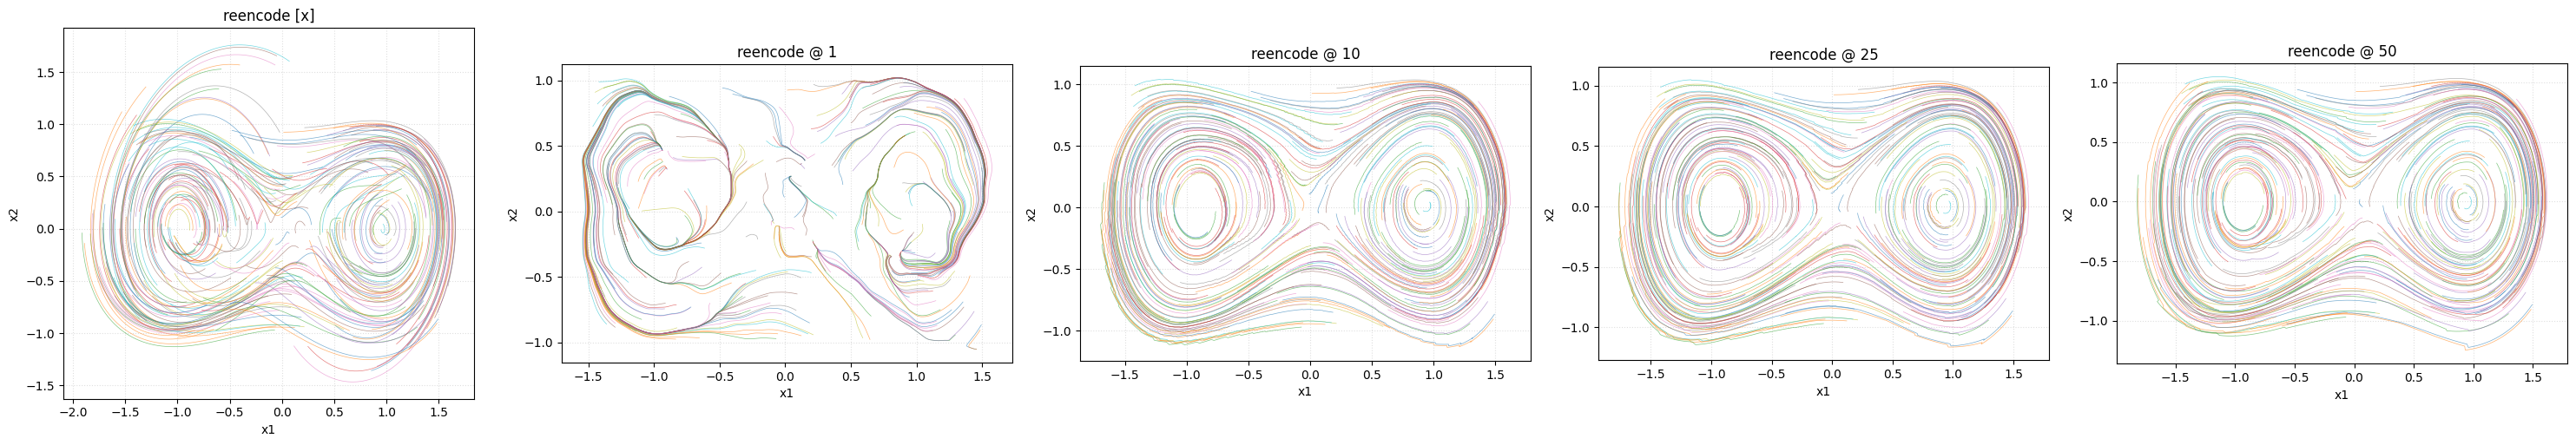

In [28]:
# Visualize trajectories - matches the evaluation style from train.py
# Uses _save_jax_style_phase_portraits style with different reencoding periods

env = make_env(cfg)
batch_size = 256  # Match phase_portrait_batch_size from EvaluationSettings
length = 200  # Match phase_portrait_length from EvaluationSettings
reencode_periods = (0, 1, 10, 25, 50)  # Match phase_portrait_reencode_periods

vec_env = VectorWrapper(env, batch_size=batch_size)
rng = torch.Generator().manual_seed(cfg.SEED + 12345 + 999)  # Match seed_offset from evaluation
init_states = vec_env.reset(rng)

# Generate trajectories for each reencoding period
trajectories = {}
model.eval()
with torch.no_grad():
    for period in reencode_periods:
        traj = _make_km_env_n_step(model, init_states, length, period)
        trajectories[period] = traj

# Plot phase portrait grid (matching _save_jax_style_phase_portraits)
num_modes = len(reencode_periods)
fig, axes = plt.subplots(1, num_modes, figsize=(6 * num_modes, 5), squeeze=False)

for ax, period in zip(axes[0], reencode_periods):
    traj = trajectories[period]
    ax.plot(traj[:, :, 0].numpy(), traj[:, :, 1].numpy(), linewidth=0.5, alpha=0.6)
    if period == 0:
        title = "reencode [x]"
    elif period == 1:
        title = "reencode @ 1"
    else:
        title = f"reencode @ {period}"
    ax.set_title(title)
    ax.set_xlabel("x1")
    ax.set_ylabel("x2")
    ax.set_aspect("equal", adjustable="box")
    ax.grid(True, linestyle=":", alpha=0.4)

fig.tight_layout()
plt.show()

### Plot Prediction Error Over Time

Compare how different rollout strategies accumulate error.


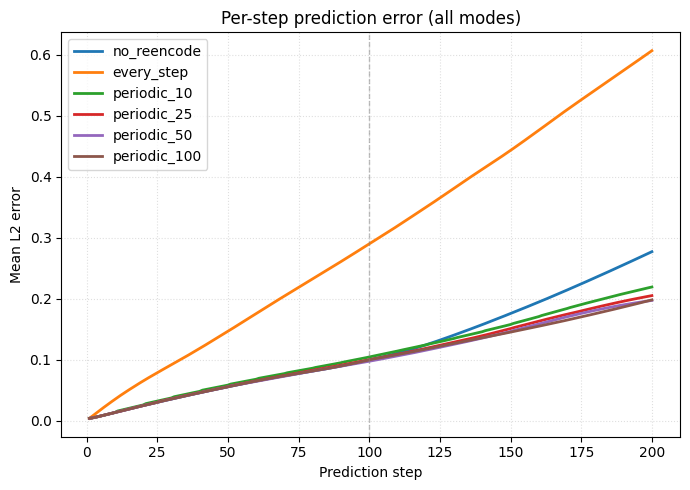


Final step errors:
  no_reencode: 0.2769
  every_step: 0.6065
  periodic_10: 0.2190
  periodic_25: 0.2048
  periodic_50: 0.1970
  periodic_100: 0.1978


In [29]:
# Compute per-step errors for all rollout modes
# Matches _save_error_curve_combined style from evaluation.py

# Generate ground truth for comparison
true_traj = generate_trajectory(vec_env.step, init_states, length=length)

# Compute errors for each mode
per_step_errors = {}
for period in reencode_periods:
    pred = trajectories[period]
    error = torch.norm(pred - true_traj, dim=-1).mean(dim=1)
    if period == 0:
        mode_name = "no_reencode"
    elif period == 1:
        mode_name = "every_step"
    else:
        mode_name = f"periodic_{period}"
    per_step_errors[mode_name] = error

# Also add periodic reencoding modes for comprehensive comparison
periodic_periods = [10, 25, 50, 100]
model.eval()
with torch.no_grad():
    for period in periodic_periods:
        if period not in reencode_periods:
            pred = rollout_periodic_reencode(model, init_states.to(DEVICE), length, period=period)
            error = torch.norm(pred.cpu() - true_traj, dim=-1).mean(dim=1)
            per_step_errors[f"periodic_{period}"] = error

# Plot combined error curve (matching _save_error_curve_combined)
highlight_steps = [100, 1000]  # Match horizons from EvaluationSettings

fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for mode_name, errors in per_step_errors.items():
    error_np = errors.cpu().numpy()
    steps = np.arange(1, error_np.shape[0] + 1)
    ax.plot(steps, error_np, linewidth=2, label=mode_name)

# Add highlight lines for horizons
for step in highlight_steps:
    if step <= length:
        ax.axvline(step, color="gray", linestyle="--", linewidth=1.0, alpha=0.5)

ax.set_xlabel("Prediction step")
ax.set_ylabel("Mean L2 error")
ax.set_title("Per-step prediction error (all modes)")
ax.grid(True, linestyle=":", alpha=0.4)
ax.legend()
fig.tight_layout()
plt.show()

# Print final step errors
print("\nFinal step errors:")
for mode_name, errors in per_step_errors.items():
    print(f"  {mode_name}: {errors[-1]:.4f}")


---

## 9. Additional Experiments

Here are templates for running other experiments with different configurations.


In [24]:
# Example 2: Train on the Pendulum system
# Uncomment and run to train on pendulum

# cfg_pendulum = get_config("generic_sparse")
# cfg_pendulum.ENV.ENV_NAME = "pendulum"
# cfg_pendulum.TRAIN.NUM_STEPS = 5000
# cfg_pendulum.MODEL.SPARSITY_COEFF = 0.01

# model_pendulum = train(
#     cfg=cfg_pendulum,
#     log_dir='./runs/pendulum',
#     device=DEVICE,
# )


In [25]:
# Example 3: Train on the Lyapunov Multi-Attractor system
# This is a more challenging system with 13 stable equilibria

# cfg_lyapunov = get_config("generic_sparse")
# cfg_lyapunov.ENV.ENV_NAME = "lyapunov"
# cfg_lyapunov.TRAIN.NUM_STEPS = 10000
# cfg_lyapunov.MODEL.TARGET_SIZE = 64
# cfg_lyapunov.MODEL.SPARSITY_COEFF = 0.001
# cfg_lyapunov.MODEL.PRED_COEFF = 1.0

# model_lyapunov = train(
#     cfg=cfg_lyapunov,
#     log_dir='./runs/lyapunov',
#     device=DEVICE,
# )


In [26]:
# Example 4: Train LISTA-based sparse encoder
# Uses overcomplete dictionary for sparse coding

# cfg_lista = get_config("lista")
# cfg_lista.ENV.ENV_NAME = "duffing"
# cfg_lista.TRAIN.NUM_STEPS = 10000
# cfg_lista.MODEL.TARGET_SIZE = 128  # Overcomplete representation

# model_lista = train(
#     cfg=cfg_lista,
#     log_dir='./runs/lista',
#     device=DEVICE,
# )


In [27]:
# Example 5: Sparsity coefficient sweep
# Compare different sparsity regularization strengths

# sparsity_coeffs = [0.0, 0.001, 0.01, 0.1]
# results = {}

# for sparsity in sparsity_coeffs:
#     print(f"\n{'='*60}")
#     print(f"Training with sparsity_coeff = {sparsity}")
#     print('='*60)
#
#     cfg_sweep = get_config("generic_sparse")
#     cfg_sweep.ENV.ENV_NAME = "duffing"
#     cfg_sweep.TRAIN.NUM_STEPS = 5000
#     cfg_sweep.MODEL.SPARSITY_COEFF = sparsity
#
#     model_sweep = train(
#         cfg=cfg_sweep,
#         log_dir=f'./runs/sparsity_sweep_{sparsity}',
#         device=DEVICE,
#         run_evaluation=False,
#     )
#
#     # Quick evaluation
#     eval_results = evaluate_model(model_sweep, cfg_sweep, device=DEVICE)
#     results[sparsity] = eval_results

# print("\n" + "="*60)
# print("SPARSITY SWEEP SUMMARY")
# print("="*60)
# for sparsity, res in results.items():
#     if "duffing" in res:
#         mse_100 = res["duffing"]["modes"]["every_step"]["horizons"]["100"]["mean"]
#         print(f"Sparsity {sparsity}: MSE@100 = {mse_100:.4e}")


---

## Summary

This notebook provides a complete, self-contained implementation of Sparse Koopman Autoencoders for learning dynamics of nonlinear systems.

### Key Components

1. **Configuration System**: Flexible dataclass-based configuration with presets
2. **Dynamical Systems**: 6 different environments (Duffing, Pendulum, Lotka-Volterra, Lorenz63, Parabolic, Lyapunov)
3. **Models**: GenericKM (MLP encoder) and LISTAKM (sparse LISTA encoder)
4. **Training**: AdamW optimizer with separate learning rates for Koopman matrix
5. **Evaluation**: Multiple rollout strategies with horizon-wise MSE metrics

